In [ ]:
import keras
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import gc
import pickle

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(1)

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [

        iaa.Fliplr(0.5),
        iaa.Flipud(0.2),

        sometimes(iaa.Crop(percent=(0, 0.1))),

        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        iaa.SomeOf((0, 5),
            [

                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),
                iaa.Invert(0.05, per_channel=True),
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.Multiply((0.5, 1.5), per_channel=0.5),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [ ]:
# 0-main, 1-other
df = pd.DataFrame({"name":[], "num":[]})
df

,name,num


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAINING_DIR = "/content/drive/MyDrive/pages/source/"

In [ ]:
def full_df(dir):
  doc_names = []
  doc_nums = []
  for _, _, files in os.walk(dir, topdown=False):
   for name in files:
      num = (os.path.splitext(os.path.basename(name))[0])[-2:]
      if re.search(r'\d+', num):
        if int(re.search(r'\d+', num).group()) == 1 or int(re.search(r'\d+', num).group()) == 0:
          doc_nums.append(0)
        else:
          doc_nums.append(1)
      else: 
        doc_nums.append(0)
      doc_names.append(name)
  return doc_nums, doc_names

df['num'], df['name'] = full_df(TRAINING_DIR)
df

,name,num
0,fyg65f00.tif,0
1,dkn80f00.tif,0
2,hua33a00-init.tif,0
3,pkj90c00.tif,0
4,pfk90c00.tif,0
...,...,...
995,skj51f00_1.tif,0
996,skj51f00_2.tif,1
997,skj51f00_3.tif,1
998,skj51f00_4.tif,1


In [ ]:
def img_generator(gen_df):
    x = []
    y = []

    for i in range(len(gen_df)):
        doc_name = gen_df['name'].iloc[i]
        doc_num = gen_df['num'].iloc[i]
        doc = cv2.imread(TRAINING_DIR + doc_name)
        doc = cv2.resize(doc, (256, 256))

        x += [doc]
        y += [doc_num]

    x = np.array(x) / 255.
    y = np.array(y)

    return x, y
    
x, y = img_generator(df)

In [ ]:
def aug_generator(x, y):
    x_aug = []
    y_aug = []

    for _ in range(3):
        doc_aug = seq(images=x.astype(np.uint8))

        x_aug += [doc_aug]
        y_aug += [y]

    x_aug = np.array(x_aug).reshape(3000,256,256,3)
    y_aug = np.array(y_aug).reshape(3000,1)

    return x_aug, y_aug
    
x_aug, y_aug = aug_generator(x, y)

In [ ]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
model = Sequential()

model.add(Conv2D(4, (2, 2), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(8, (2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(16, (2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())

# model.add(Dense(7200, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(3600, activation='sigmoid'))
#model.add(Dropout(0.25))
# model.add(Dense(90, activation='relu'))
model.add(Dense(18, activation='sigmoid'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mse', optimizer='SGD', metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 255, 255, 4)       52        
_________________________________________________________________
batch_normalization_33 (Batc (None, 255, 255, 4)       16        
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 127, 127, 4)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 126, 126, 8)       136       
_________________________________________________________________
batch_normalization_34 (Batc (None, 126, 126, 8)       32        
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 62, 62, 16)      

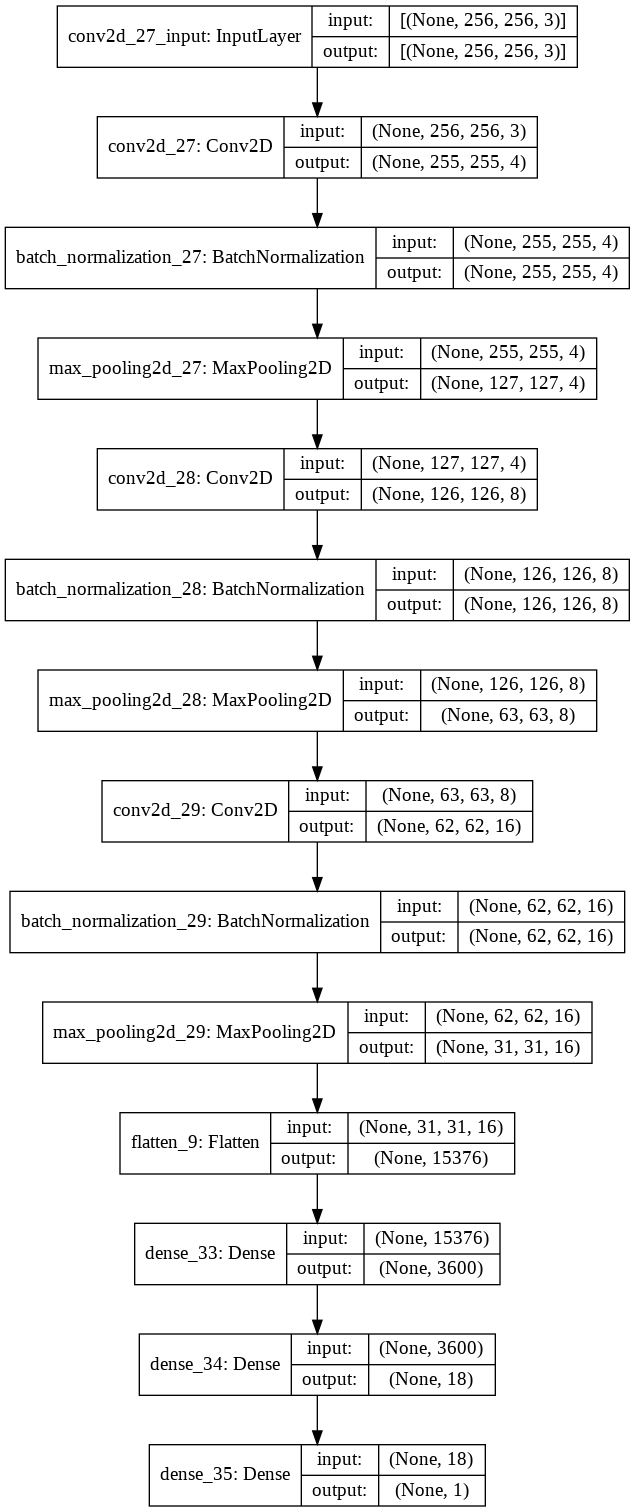

In [ ]:
keras.utils.plot_model(model, 
                      to_file = "model.png",
                      show_shapes=True,
                      show_dtype=False,
                      show_layer_names=True,
                      rankdir="TB",
                      expand_nested=False)

In [ ]:
#checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [ ]:
#предтрен на аугментах

batch_size = 16
epochs=20
model.fit(x = x_aug, y = y_aug, 
          batch_size = batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=None,
          validation_data=(x, y),
          class_weight=None,
          max_queue_size=10,
          workers=1,
          use_multiprocessing=False,
          shuffle=True,
          initial_epoch=0)

Epoch 1/20
188/188 [==============================] - 5s 24ms/step - loss: 0.2638 - accuracy: 0.5374 - val_loss: 0.2460 - val_accuracy: 0.5720
Epoch 2/20
188/188 [==============================] - 4s 20ms/step - loss: 0.2436 - accuracy: 0.5639 - val_loss: 0.2451 - val_accuracy: 0.5720
Epoch 3/20
188/188 [==============================] - 4s 20ms/step - loss: 0.2407 - accuracy: 0.5688 - val_loss: 0.2582 - val_accuracy: 0.5720
Epoch 4/20
188/188 [==============================] - 4s 20ms/step - loss: 0.2399 - accuracy: 0.5764 - val_loss: 0.2490 - val_accuracy: 0.5720
Epoch 5/20
188/188 [==============================] - 4s 20ms/step - loss: 0.2278 - accuracy: 0.6035 - val_loss: 0.2492 - val_accuracy: 0.5720
Epoch 6/20
188/188 [==============================] - 4s 20ms/step - loss: 0.2244 - accuracy: 0.6107 - val_loss: 0.2579 - val_accuracy: 0.4280
Epoch 7/20
188/188 [==============================] - 4s 20ms/step - loss: 0.2212 - accuracy: 0.6215 - val_loss: 0.2434 - val_accuracy: 0.5720

In [ ]:
model.save('/content/drive/MyDrive/pages/Model1/model.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/pages/assets


In [ ]:
del model
gc.collect()

1684

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
batch_size = 16
epochs=20
model.fit(x = x_train, y = y_train, 
          batch_size = batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=None,
          validation_data=(x_test, y_test),
          class_weight=None,
          max_queue_size=10,
          workers=1,
          use_multiprocessing=False,
          shuffle=True,
          initial_epoch=0)

Epoch 1/20
50/50 [==============================] - 2s 29ms/step - loss: 0.2694 - accuracy: 0.6096 - val_loss: 0.2318 - val_accuracy: 0.5950
Epoch 2/20
50/50 [==============================] - 1s 24ms/step - loss: 0.1219 - accuracy: 0.8545 - val_loss: 0.4111 - val_accuracy: 0.4050
Epoch 3/20
50/50 [==============================] - 1s 23ms/step - loss: 0.1097 - accuracy: 0.8340 - val_loss: 0.3563 - val_accuracy: 0.4050
Epoch 4/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0760 - accuracy: 0.9138 - val_loss: 0.3357 - val_accuracy: 0.4250
Epoch 5/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0494 - accuracy: 0.9584 - val_loss: 0.3859 - val_accuracy: 0.4250
Epoch 6/20
50/50 [==============================] - 1s 24ms/step - loss: 0.0399 - accuracy: 0.9709 - val_loss: 0.2403 - val_accuracy: 0.5100
Epoch 7/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0285 - accuracy: 0.9813 - val_loss: 0.2951 - val_accuracy: 0.4600
Epoch 8/20
50

In [ ]:
model.save('/content/drive/MyDrive/pages/Model2/model2.h5')